# [EX10] 뉴스기사 요약해보기

#### * 목차
1. 데이터 수집하기
2. 데이터 전처리하기 (추상적 요약)    
    1) 데이터 수집하기    
    2) 데이터 분리    
    3) 단어집합 만들기, 정수 인코딩하기    
3. 어텐션 메커니즘 사용하기 (추상적 요약)
4. 실제 결과와 요약문 비교하기 (추상적 요약)
5. Summa을 이용해서 추출적 요약해보기
6. 요약 결과 비교

## 1. 데이터 수집하기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
21144,US concerned over Russian satellite's 'abnorma...,The US has expressed concerns over a Russian s...
9022,"47-year-old Tambe takes hat-trick, 1st ever fi...",Sindhis' 47-year-old Indian leg-spinner Pravin...
4232,Bumrah becomes top wicket-taker in internation...,India fast bowler Jasprit Bumrah has become th...
86515,IPL viewership increased by over 20% in 2017: ...,As per a Broadcast Audience Research Council r...
66015,Scientists discover ring around a dwarf planet...,"In a first, Europe-based astronomers have disc..."
20040,We feel we shouldn't make Iqbal's sequel: Shre...,"Actor Shreyas Talpade, while talking about his..."
35773,"Parents, sister sentenced to life for murderin...",A Haryana court has awarded life sentence to p...
45964,Pichai holds no authority over resource alloca...,Google CEO Sundar Pichai doesn't have authorit...
26885,After yrs wife allowed me to post pic I took: ...,"Actor Shah Rukh Khan, while sharing a selfie w..."
53963,Cong calls PM Modi 'mauni baba' over silence o...,Slamming Prime Minister Narendra Modi over his...


## 2. 데이터 전처리하기 (추상적 요약)

### 1) 데이터 수집하기

In [4]:
# 데이터 중복 후 개수 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
# headlines 중복 샘플 제거
data.drop_duplicates(subset = ['headlines'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98280


In [6]:
# 데이터프레임에 Null값이 있는지 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [7]:
# 텍스트 정규화 및 불용화 제거
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [11]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 (10분정도 소요)
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [12]:
clean_headline = []

# 전체 Summary 데이터에 대한 전처리 (5분정도 소요)
for s in data['headlines']:
    clean_headline.append(preprocess_sentence(s, False))

clean_headline[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [13]:
# 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있으므로 빈 값을 Null로 변환

data['text'] = clean_text
data['headlines'] = clean_headline

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10031542531542
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.2995115995116


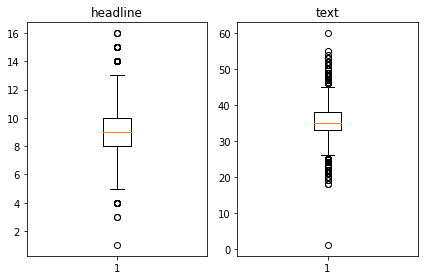

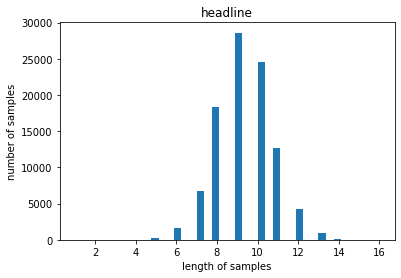

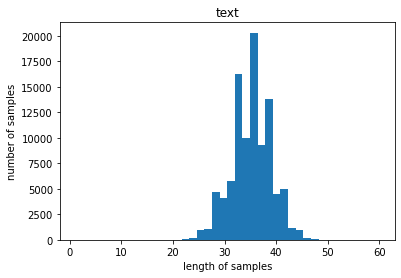

In [15]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headline_len)))
print('요약의 최대 길이 : {}'.format(np.max(headline_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
# 최대길이 임의 설정
text_max_len = 38
headline_max_len = 11

In [17]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if (len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8163105413105413
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.944993894993895


In [19]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 75692


In [20]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가.

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...
8,called pm modi sir times to satisfy his ego an...,andhra pradesh cm chandrababu naidu said met u...,sostoken called pm modi sir times to satisfy h...,called pm modi sir times to satisfy his ego an...


In [21]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 2) 데이터 분리

In [22]:
# 훈련 데이터 테스트 데이터 분리
indices = np.arange(encoder_input.shape[0]) # encoder_input과 크기와 형태가 같은 정수 시퀀스 생성
np.random.shuffle(indices) # 랜덤하게 섞기
print(indices) # 순서가 섞인 정수 시퀀스 생성

[37737 30325 48693 ... 46413 42215 16766]


In [23]:
# 샘플 순서를 랜덤 시퀀스를 이용해서 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [24]:
# 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 15138


In [25]:
# 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분

encoder_input_train = encoder_input[:-n_of_val] # 맨뒤 n_of_val개를 제외한 나머지
decoder_input_train = decoder_input[:-n_of_val] 
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:] # 맨앞 n_of_val개를 제외한 나머지
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 : ', len(encoder_input_train))
print('훈련 레이블의 개수 : ', len(decoder_input_train))
print('테스트 데이터의 개수 : ', len(encoder_input_test))
print('테스트 데이터의 개수 : ', len(decoder_input_test))

훈련 데이터의 개수 :  60554
훈련 레이블의 개수 :  60554
테스트 데이터의 개수 :  15138
테스트 데이터의 개수 :  15138


### 3) 단어집합 만들기, 정수 인코딩하기

In [26]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [27]:
threshold = 8 # 등장 빈도수
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 60298
등장 빈도가 7번 이하인 희귀 단어의 수: 42578
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17720
단어 집합에서 희귀 단어의 비율: 70.61262396762746
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.545664956197134


In [28]:
src_vocab = 17000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 11,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])
print(encoder_input_test[:3])

[[188, 836, 1269, 397, 78, 398, 348, 156, 1327, 1410, 634, 4146, 345, 277, 2110, 275, 3106, 2043, 54, 562, 1318, 965, 10847, 1210, 85, 118, 3535, 281, 223, 227, 3954, 3106, 92], [630, 11578, 13523, 14869, 14151, 535, 630, 4838, 897, 1606, 6020, 103, 469, 3161, 111, 5168, 7583, 11578, 1, 897, 1606, 975, 11190, 979, 349, 475], [494, 9, 52, 2321, 477, 16614, 179, 6917, 3536, 199, 2816, 1781, 9, 258, 4114, 546, 62, 93, 6311, 5293, 65, 511, 561, 383, 424, 1431, 6597, 117, 28, 9, 1177, 4303, 477, 4528, 167, 888]]
[[213, 3, 13, 337, 885, 3726, 6083, 73, 129, 293, 3719, 7, 1, 301, 337, 483, 536, 511, 2667, 8233, 1609, 2835, 86, 5596, 3279, 7, 2, 167, 8, 1165, 878, 858], [427, 1737, 1620, 347, 55, 41, 663, 19, 264, 163, 1017, 39, 160, 326, 9, 503, 1896, 1718, 58, 252, 163, 374, 189, 15, 148, 75, 1237, 355, 1, 193, 77, 75, 1746, 10, 112, 975], [1632, 32, 19, 3723, 2510, 427, 1366, 2241, 3827, 5742, 50, 5519, 4101, 1, 41, 2491, 4750, 2510, 1660, 1366, 278, 543, 41, 21, 4101, 1228, 472, 3220, 61, 

In [30]:
# headlines 에도 적용
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [31]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 26998
등장 빈도가 6번 이하인 희귀 단어의 수: 18784
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8214
단어 집합에서 희귀 단어의 비율: 69.57552411289724
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.3982873987504405


In [32]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 168, 99, 170, 6, 1733, 9, 5162, 37, 1082], [1, 23, 12, 2131, 5163, 880, 414, 20, 977, 464], [1, 594, 22, 3, 1624, 325, 388, 5791, 14, 279], [1, 2238, 978, 152, 1083, 5, 6547, 521, 64], [1, 4188, 84, 21, 102, 3, 2092, 17, 4704, 949, 9, 3617]]
target
decoder  [[168, 99, 170, 6, 1733, 9, 5162, 37, 1082, 2], [23, 12, 2131, 5163, 880, 414, 20, 977, 464, 2], [594, 22, 3, 1624, 325, 388, 5791, 14, 279, 2], [2238, 978, 152, 1083, 5, 6547, 521, 64, 2], [4188, 84, 21, 102, 3, 2092, 17, 4704, 949, 9, 3617, 2]]


In [33]:
# 빈도수가 낮은 단어들로만 구성되었던 문장들을 제거
# headline의 길이가 1인 경우 drop
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 60553
훈련 레이블의 개수 : 60553
테스트 데이터의 개수 : 15138
테스트 레이블의 개수 : 15138


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [34]:
# 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어줌
# 아까 정해두었던 최대 길이로 패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headline_max_len, padding='post')

## 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [35]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout = 0.4 )
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [36]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [37]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2176000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [38]:
# GitHub의 어텐션 함수 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [39]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2176000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
237/237 [==============================] - 155s 607ms/step - loss: 6.2589 - val_loss: 5.4679
Epoch 2/50
237/237 [==============================] - 147s 623ms/step - loss: 5.4395 - val_loss: 5.1230
Epoch 3/50
237/237 [==============================] - 147s 620ms/step - loss: 5.0857 - val_loss: 4.8607
Epoch 4/50
237/237 [==============================] - 144s 608ms/step - loss: 4.7922 - val_loss: 4.6473
Epoch 5/50
237/237 [==============================] - 144s 608ms/step - loss: 4.5657 - val_loss: 4.4985
Epoch 6/50
237/237 [==============================] - 143s 602ms/step - loss: 4.3544 - val_loss: 4.3753
Epoch 7/50
237/237 [==============================] - 142s 598ms/step - loss: 4.1851 - val_loss: 4.2651
Epoch 8/50
237/237 [==============================] - 141s 594ms/step - loss: 4.0372 - val_loss: 4.1939
Epoch 9/50
237/237 [==============================] - 140s 591ms/step - loss: 3.9095 - val_loss: 4.1284
Epoch 10/50
237/237 [==============================] - 141s 594m

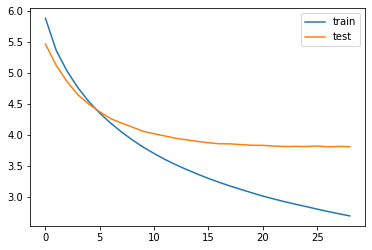

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [42]:
# 정수 인덱스로 되어있던 텍스트 데이터를 실제 데이터로 복원하기
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [43]:
# 인퍼런스 단계에서는 인코더 모델과 디코더 모델 분리해서 설계

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해 초기 상태를 이전 시점 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련과정과 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h, state_c 를 버리지 않음
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [44]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [45]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [46]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [47]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : bengaluru named th cheapest city world economist intelligence unit cost living index chennai ranked th cheapest location new delhi listed th spot survey mentioned within asia best value money traditionally particularly offered indian pakistani cities 
실제 요약 : indian cities named among world cheapest cities 
예측 요약 :  bengaluru to host world th largest cryptocurrency


원문 : us president donald trump saturday blamed paris climate agreement protests continued france increase fuel taxes government policies protests riots france people want pay large money much third world countries order maybe protect environment trump tweeted 
실제 요약 : trump blames paris climate agreement for protests in france 
예측 요약 :  trump threatens to paris climate deal ban


원문 : mudslides flash floods triggered tropical storm philippines killed around people left thousands homeless disaster officials said many residents ignored warnings leave coastal areas super typhoon killed nearly people left families homeles

예측 요약 :  rape case against kerala nun who tried to kerala hc


원문 : shiv sena saturday said renaming cities uttar pradesh chief minister yogi adityanath lure voters ahead lok sabha polls next year political party also criticised cm announcement construction statue lord ram saying demand ram temple 
실제 요약 : renaming up cities from bjp to voters shiv sena 
예측 요약 :  sena adityanath calls up cm yogi for up


원문 : earnings crore first day ranbir kapoor starrer sanju become highest opening day grosser broke record set salman khan race earned crore first day sanju biopic actor sanjay dutt also highest opening day grosser ranbir career 
실제 요약 : sanju beats salman race to become highest opener 
예측 요약 :  sanju becomes ishaan highest opening opening grosser of


원문 : journalist jamal khashoggi strangled soon entered saudi arabia consulate istanbul body cut pieces turkish prosecutor said wednesday khashoggi critic saudi government gone consulate paperwork related divorce saudi arabia admitted last

예측 요약 :  manikarnika is not responsible for manikarnika kangana


원문 : afghanistan team set replace australia side tri series south africa shall also feature india team replacement come australian team pulled due ongoing pay dispute players cricket australia notably afghanistan team granted test status last month 
실제 요약 : afghanistan to replace aus in series featuring india 
예측 요약 :  afghanistan to play test in australia for champions trophy


원문 : video emerged online wherein gujarat cm vijay rupani heard directing police officers move martyred bsf soldier daughter side rally sister meet rally rupani heard saying claimed family given land promised father martyred 
실제 요약 : guj cm orders cops to move martyr daughter out of rally 
예측 요약 :  taka cm orders slain slain jawan of love jihad




## 5. Summa을 이용해서 추출적 요약해보기

In [48]:
from summa.summarizer import summarize

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [50]:
text = data['text']
text[0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [51]:
print('Summary:')
print(summarize(text[0], words=5))

Summary:
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [52]:
# 리스트로 출력 받기
print('Summary:')
print(summarize(text[0], ratio=0.4, split=True))

Summary:
["upGrad's Online Power Learning has powered 3 lakh+ careers."]


In [53]:
headlines = [] # 3분정도 소요
for i in range(len(text)):
    headline = summarize(text[i], ratio=0.4)
    headlines.append(headline)

In [54]:
headlines[:5]

["upGrad's Online Power Learning has powered 3 lakh+ careers.",
 'Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.',
 'The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.',
 'Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.',
 'Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I\'ve known Hirani for many years...What if it\'s not true, the [#MeToo] movement will get derailed." "In the #MeToo movement, I always believe a woman.']

In [55]:
for i in range(10):
    print("원문 :", data['text'][i])
    print("실제 헤드라인 :", data['headlines'][i])
    print("예측 헤드라인 :", headlines[i])
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 헤드라인 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 헤드라인 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 헤드라인 : Delhi techie wins free food from Swiggy for one year on CRED
예측 헤드라인 : Users get one CRED coin per rupee of 

## 6. 요약 결과 비교

### 텍스트 요약(Text summarization)
#### * 추출적 요약 (Extractive summarization)    
    - 입력으로 주어진 문서 집합 "내"에서 중요한 문장이나 단어를 선택하는 방법     
    - 'Text Rank', Gensim 라이브러리의 'Summarizer 함수' 방법 등 있음   
    
#### * 추상적 요약 (Abstractive summarization)    
    - 입력값의 상대적 중요도에 따라 가장 중요한 일부 문장이나 단어을 선별하는 방법   
    - Seq2Seq, Attention Mechanism 방법 등이 있음
<br>

### 문법완성도 측면 비교    
    - 추상적 요약은 각 어휘들이 출현한 위치와 주변 단어의 관계로부터 중요도를 계산하고, 품사와 문법적인 구조를 함께 반영함므로,
      추출적 요약에 비해 명확하고 매끄러운 문장 구조를 가지고 있음
    - 하지만, 불필요한 단어 중복이 많고, 실제 내용과 관련이 없는 요약 결과 확률이 높았음
<br>

### 핵심단어 포함 측면 비교
    - 추출적 요약은 주어진 데이터 내에서 단어를 추출하므로, 추상적 요약에 비해 실제 내용과 관련이 없는 요약 결과기 나올 확률이 낮음
    - 하지만, 선별된 단어들이 문장 전체를 충분히 대표하지 못하고, 선별된 단어들 간의 호응이 떨어짐이 존재함   
